<a href="https://colab.research.google.com/github/omarjilanijidan/Iris-Cataract-Detection-From-Fundus-Images/blob/main/VGG19_with_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# New Section

In [2]:
import os
import numpy as np
import cv2
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Model

In [3]:
# Authenticate and mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
image_size = 224

In [5]:
# Define file paths for saved data
load_path = '/content/drive/MyDrive/Papers/Dataset Fundus Image/augmented-data'
train_images_path = os.path.join(load_path, 'X_train.npy')
train_labels_path = os.path.join(load_path, 'y_train.npy')
test_images_path = os.path.join(load_path, 'X_test.npy')
test_labels_path = os.path.join(load_path, 'y_test.npy')

# Load training and testing data from saved files
X_train = np.load(train_images_path)
y_train = np.load(train_labels_path)
X_test = np.load(test_images_path)
y_test = np.load(test_labels_path)

In [6]:
# Print number of images used for training and testing
print(f"Number of images used for training: {len(X_train)}")
print(f"Number of images used for testing: {len(X_test)}")

Number of images used for training: 3997
Number of images used for testing: 1004


In [7]:
# Create VGG19 base model
vgg19 = VGG19(include_top=False, weights="imagenet", input_shape=(image_size, image_size, 3))

80134624/80134624 [==============================] - 1s 0us/step


In [8]:
# Freeze base model layers
for layer in vgg19.layers:
    layer.trainable = False

In [9]:
from tensorflow.keras.layers import GlobalAveragePooling2D
# Create custom model with VGG19 base and fully connected layers
inputs = vgg19.input
outputs = vgg19.output
outputs = Dropout(0.5)(outputs)
outputs = Dense(512, activation="relu")(outputs)
outputs = Dropout(0.5)(outputs)
outputs = Dense(49, activation="sigmoid")(outputs)
outputs = GlobalAveragePooling2D()(outputs)
predictions = Dense(1, activation="sigmoid")(outputs)
model = Model(inputs=inputs, outputs=predictions)

In [10]:
# Compile model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [11]:
# Fit model on train data
history = model.fit(X_train, y_train, epochs=5, batch_size=49, validation_data=(X_test, y_test))

Epoch 1/5
82/82 [==============================] - 1854s 23s/step - loss: 0.3502 - accuracy: 0.8697 - val_loss: 0.1907 - val_accuracy: 0.9283
Epoch 2/5
82/82 [==============================] - 1840s 22s/step - loss: 0.1727 - accuracy: 0.9452 - val_loss: 0.1628 - val_accuracy: 0.9303
Epoch 3/5
82/82 [==============================] - 1818s 22s/step - loss: 0.1476 - accuracy: 0.9527 - val_loss: 0.1288 - val_accuracy: 0.9612
Epoch 4/5
82/82 [==============================] - 1837s 22s/step - loss: 0.1326 - accuracy: 0.9565 - val_loss: 0.1278 - val_accuracy: 0.9482
Epoch 5/5
82/82 [==============================] - 1816s 22s/step - loss: 0.1290 - accuracy: 0.9560 - val_loss: 0.1220 - val_accuracy: 0.9582


In [12]:
# Print maximum training accuracy
max_train_acc = max(history.history["accuracy"])
print(f"Maximum training accuracy: {max_train_acc:.4f}")

# Print maximum validation accuracy
max_val_acc = max(history.history["val_accuracy"])
print(f"Maximum validation accuracy: {max_val_acc:.4f}")

# Print minimum training loss
min_train_loss = min(history.history["loss"])
print(f"Minimum training loss: {min_train_loss:.4f}")

# Print minimum validation loss
min_val_loss = min(history.history["val_loss"])
print(f"Minimum validation loss: {min_val_loss:.4f}")

Maximum training accuracy: 0.9565
Maximum validation accuracy: 0.9612
Minimum training loss: 0.1290
Minimum validation loss: 0.1220


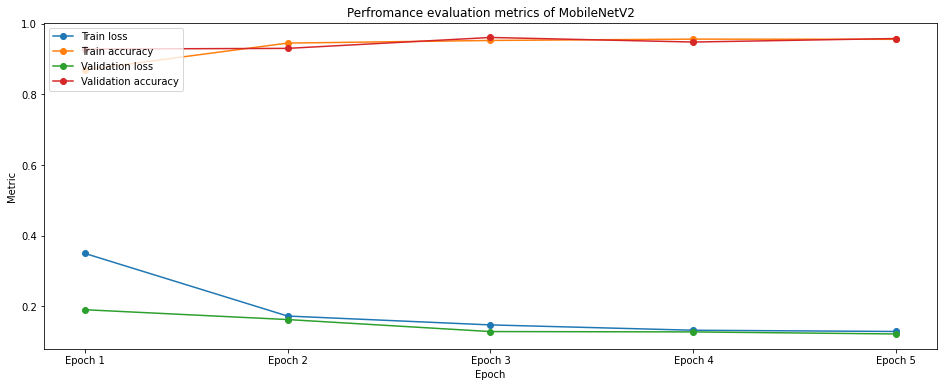

In [13]:
# Extract metric histories
loss = history.history['loss']
acc = history.history['accuracy']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']

# Create plot
fig, ax = plt.subplots(figsize=(16, 6))

# Get epoch names
epoch_names = ['Epoch {}'.format(i) for i in range(1, len(loss) + 1)]

# Plot loss, accuracy, validation loss, and validation accuracy as a combination of lines and dots over epochs
ax.plot(epoch_names, loss, '-o', label='Train loss')
ax.plot(epoch_names, acc, '-o', label='Train accuracy')
ax.plot(epoch_names, val_loss, '-o', label='Validation loss')
ax.plot(epoch_names, val_acc, '-o', label='Validation accuracy')

# Add legend and labels
ax.legend(loc='upper left')
ax.set_title('Perfromance evaluation metrics of MobileNetV2')
ax.set_ylabel('Metric')
ax.set_xlabel('Epoch')

plt.show()

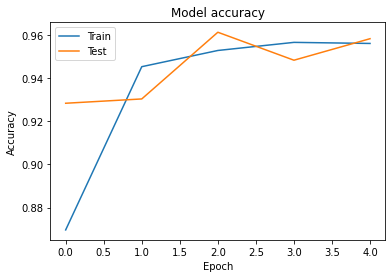

In [14]:
# Plot accuracy and loss during training
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Test"], loc="upper left")
plt.show()

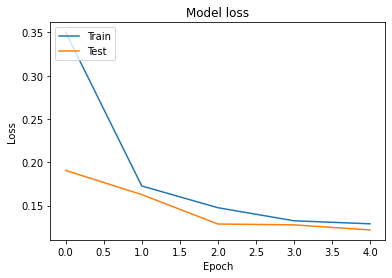

In [15]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Test"], loc="upper left")
plt.show()

In [16]:
# Get model evaluation on test data
evaluation = model.evaluate(X_test, y_test, verbose=0)

# Print model evaluation
print(f"Test loss: {evaluation[0]}")
print(f"Test accuracy: {evaluation[1]}")

Test loss: 0.12199463695287704
Test accuracy: 0.958167314529419


In [17]:
from sklearn.metrics import confusion_matrix
# Make predictions on the test data
y_pred = model.predict(X_test)

# Threshold predictions to create a binary classification
y_pred = (y_pred > 0.5).astype(int)

# Get the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Calculate specificity
specificity = cm[0][0] / (cm[0][0] + cm[0][1])
print("Specificity:", specificity)

32/32 [==============================] - 366s 11s/step
Specificity: 0.9720558882235529


In [18]:
from sklearn.metrics import classification_report
# Print classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       501
           1       0.97      0.94      0.96       503

    accuracy                           0.96      1004
   macro avg       0.96      0.96      0.96      1004
weighted avg       0.96      0.96      0.96      1004



In [19]:
# Install latest version of mlxtend library
!pip install -U mlxtend

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 18.3 MB/s eta 0:00:00
  Attempting uninstall: mlxtend
    Found existing installation: mlxtend 0.14.0
    Uninstalling mlxtend-0.14.0:
      Successfully uninstalled mlxtend-0.14.0


(<Figure size 576x504 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb2d39d7df0>)

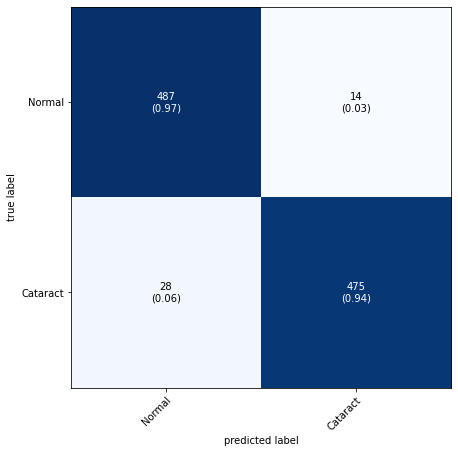

In [20]:
# Import plot_confusion_matrix function
from mlxtend.plotting import plot_confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plot_confusion_matrix(conf_mat=cm, figsize=(8,7), class_names=["Normal", "Cataract"], show_normed=True)

2/2 [==============================] - 19s 7s/step


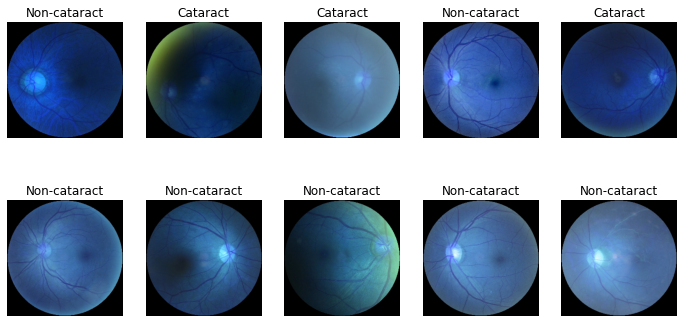

In [21]:
# Set test directory
test_dir = "/content/drive/MyDrive/Papers/Extra/preprocessed_images"

# Load test images
test_images = []
for img in os.listdir(test_dir)[:50]:
    image_path = os.path.join(test_dir, img)
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (image_size, image_size))
    image = image / 255.0
    test_images.append(image)

# Convert test images to numpy array
test_images = np.array(test_images)

# Use model to predict labels for test images
predictions = model.predict(test_images)

# Create labels for test images
labels = ["Cataract" if prediction >= 0.5 else "Non-cataract" for prediction in predictions]

# Create subplots with 2 rows and 5 columns
fig, axs = plt.subplots(2, 5, figsize=(12, 6))

# Plot test images in subplots
for ax, img, label in zip(axs.flatten(), test_images, labels):
    ax.imshow(img)
    ax.axis("off")
    ax.set(title=label)

plt.show()